In [1]:
import os
import duckdb
import time

### Data Gen Code

In [ ]:
# Generate dummy data using DuckDB SQL
def gen_dataset(rows):

    lower_bound = "2020-01-01"
    upper_bound = "2025-01-01"  

    duckdb.execute(f"""
        COPY (
        select  
              t.row_id
            , cast(uuid() as varchar(30)) as txn_key
            , date '{lower_bound}' 
            + (random() * (date_diff('day', date '{lower_bound}', date '{upper_bound}')))::int as rand_dt
            , round(random() * 100, 2) as rand_val
            , substr(
                  'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789', 
                  1, 
                  1 + (random() * 25)::int
              ) as rand_str
        from generate_series(1,{rows}) t(row_id)
        ) TO '~/dummy_data/ds_{rows}_rows.parquet' (FORMAT 'parquet')
    """)


In [ ]:
gen_dataset(500)
gen_dataset(5_000)
gen_dataset(50_000)
gen_dataset(500_000)
gen_dataset(5_000_000)
gen_dataset(50_000_000)
gen_dataset(500_000_000)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("Sledgehammer").getOrCreate()  

### Benchmark Code

In [3]:
import glob
import os
import time
import pandas as pd

def duckdb_benchmark(parquet_files):
    cn = duckdb.connect()
    results = []
    for f_path in parquet_files:
        start = time.time()
        cn.sql(f"select rand_dt, count(distinct rand_str) from read_parquet('{f_path}') group by all order by 2 desc").fetchall()
        end = time.time()
        elapsed_ms = (end - start) * 1000
        row_count = cn.sql(f"select count(*) from read_parquet('{f_path}')").fetchone()[0]
        results.append({"Engine": "DuckDB", "File": os.path.basename(f_path), "Rows": f"{row_count:,}", "Run Time (ms)": f"{elapsed_ms:.2f}"})
    return results

def spark_benchmark(parquet_files, spark):
    results = []
    for f_path in parquet_files:
        start = time.time()
        df = spark.read.parquet(f_path)
        grouped = df.groupBy("rand_dt").agg(F.count_distinct("rand_str").alias("distinct_rand_str_count")).orderBy("distinct_rand_str_count", ascending=False)
        grouped.collect()
        end = time.time()
        elapsed_ms = (end - start) * 1000
        row_count = df.count()
        results.append({"Engine": "Spark", "File": os.path.basename(f_path), "Rows": f"{row_count:,}", "Run Time (ms)": f"{elapsed_ms:.2f}"})
    return results

data_dir = os.path.expanduser("~/dummy_data/")
parquet_files = sorted(glob.glob(os.path.join(data_dir, "ds_*.parquet")))

duckdb_results = duckdb_benchmark(parquet_files)
spark_results = spark_benchmark(parquet_files, spark)


### Format the run time results as a table

In [5]:
from IPython.display import display, HTML

# Combine results and create DataFrame
all_results = duckdb_results + spark_results
df_results = pd.DataFrame(all_results)

# Convert columns to numeric for pivoting
df_results["Rows"] = df_results["Rows"].str.replace(",", "").astype(int)
df_results["Run Time (ms)"] = df_results["Run Time (ms)"].astype(float)

# Pivot and format table
pivot_df = df_results.pivot(index="Rows", columns="Engine", values="Run Time (ms)").sort_index()
pivot_df = pivot_df.rename_axis(None, axis=1).reset_index()
pivot_df = pivot_df.rename(columns={"Rows": "Row Count", "DuckDB": "DuckDb Runtime", "Spark": "Spark Runtime"})

def abbreviate_number(n):
    if n >= 1_000_000_000:
        return f"{int(n/1_000_000_000)}B"
    elif n >= 1_000_000:
        return f"{int(n/1_000_000)}M"
    elif n >= 1_000:
        return f"{int(n/1_000)}k"
    else:
        return str(n)

pivot_df["Row Count"] = pivot_df["Row Count"].apply(abbreviate_number)

# Style table with alternating row colors
def highlight_rows(row):
    color = '#ffd699' if row.name % 2 else '#ffffff'
    return [f'background-color: {color}; color: #000000; font-weight: bold;' for _ in row]

styled_table = (
    pivot_df[["Row Count", "DuckDb Runtime", "Spark Runtime"]]
    .style
    .apply(highlight_rows, axis=1)
    .set_properties(subset=["Row Count"], **{'text-align': 'left', 'color': '#000000', 'font-weight': 'bold'})
    .set_properties(subset=["DuckDb Runtime", "Spark Runtime"], **{'text-align': 'center', 'color': '#000000', 'font-weight': 'bold'})
    .format({"DuckDb Runtime": "{:.2f}", "Spark Runtime": "{:.2f}"})
    .hide(axis="index")
)

display(HTML(styled_table.to_html()))

Row Count,DuckDb Runtime,Spark Runtime
500,3.53,224.03
5k,5.52,211.97
50k,5.97,256.29
500k,14.38,285.92
5M,55.27,646.64
50M,309.45,1563.99
500M,2623.37,13055.49


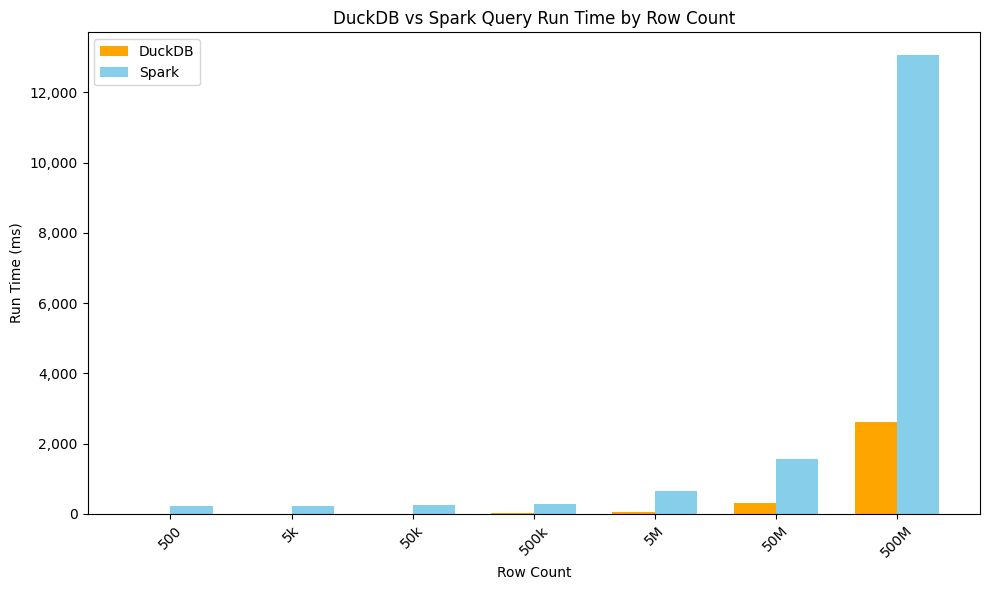

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

df_results["Rows"] = df_results["Rows"].astype(int)
df_results["Run Time (ms)"] = df_results["Run Time (ms)"].astype(float)

pivot_df = df_results.pivot(index="Rows", columns="Engine", values="Run Time (ms)").sort_index()

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(pivot_df.index))

plt.bar(x, pivot_df["DuckDB"], width=bar_width, label='DuckDB', color='orange')
plt.bar([i + bar_width for i in x], pivot_df["Spark"], width=bar_width, label='Spark', color='skyblue')

plt.xlabel('Row Count')
plt.ylabel('Run Time (ms)')
plt.title('DuckDB vs Spark Query Run Time by Row Count')
plt.xticks(
    [i + bar_width / 2 for i in x],
    [abbreviate_number(rc) for rc in pivot_df.index],
    rotation=45
)
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.legend()
plt.tight_layout()
plt.show()